In [1]:
api_key = "SV0IN2QULQJBL59E"
stock = "FBCG"

In [2]:
pip install requests -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
response = requests.get(f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={stock}&interval=15min&slice=year1month1&adjusted=true&apikey={api_key}")

In [7]:
txt = response.text.split("\r\n")
data = [t.split(",") for t in txt]
data.reverse()

df = pd.DataFrame(data[1:-1])
df.columns = data[-1]
df_data = df[["open", "high", "low", "close", "volume"]].astype(float)

Text(0.5, 1.0, 'FBCG Stock Over 1 Month')

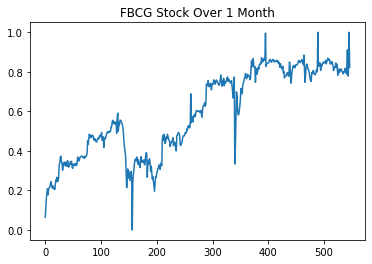

In [8]:
norm_df = (df_data - df_data.min()) / (df_data.max() - df_data.min())

plt.plot(norm_df["close"])
plt.title(f"{stock} Stock Over 1 Month")

In [9]:
lookback = 20

close_data_raw = norm_df[["close"]].to_numpy()
close_data = []

for index in range(len(close_data_raw) - lookback): 
    close_data.append(close_data_raw[index: index + lookback])

close_data = np.array(close_data)

test_size = int(np.round(0.2 * close_data.shape[0]))
train_size = close_data.shape[0] - (test_size)

print(train_size, test_size)

422 105


In [10]:
x_train1 = close_data[:train_size,:-1,:]
y_train1 = close_data[:train_size,-1,:]
    
x_test1 = close_data[train_size:,:-1]
y_test1 = close_data[train_size:,-1,:]

In [11]:
import torch
import torch.nn as nn

In [12]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [13]:
x_train = torch.from_numpy(x_train1).type(torch.Tensor)
x_test = torch.from_numpy(x_test1).type(torch.Tensor)
y_train = torch.from_numpy(y_train1).type(torch.Tensor)
y_test = torch.from_numpy(y_test1).type(torch.Tensor)

In [14]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [15]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
import time

In [17]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.1374662220478058
Epoch  1 MSE:  0.03256870433688164
Epoch  2 MSE:  0.060940444469451904
Epoch  3 MSE:  0.02958798222243786
Epoch  4 MSE:  0.030102083459496498
Epoch  5 MSE:  0.03854338079690933
Epoch  6 MSE:  0.03491462394595146
Epoch  7 MSE:  0.024798782542347908
Epoch  8 MSE:  0.018581397831439972
Epoch  9 MSE:  0.020762020722031593
Epoch  10 MSE:  0.023434335365891457
Epoch  11 MSE:  0.01857803203165531
Epoch  12 MSE:  0.011833902448415756
Epoch  13 MSE:  0.010351202450692654
Epoch  14 MSE:  0.012403682805597782
Epoch  15 MSE:  0.011174732819199562
Epoch  16 MSE:  0.0055868178606033325
Epoch  17 MSE:  0.0029169186018407345
Epoch  18 MSE:  0.006565745919942856
Epoch  19 MSE:  0.005726976785808802
Epoch  20 MSE:  0.002653134288266301
Epoch  21 MSE:  0.006317910272628069
Epoch  22 MSE:  0.006263247225433588
Epoch  23 MSE:  0.002743880497291684
Epoch  24 MSE:  0.0030677570030093193
Epoch  25 MSE:  0.003976909909397364
Epoch  26 MSE:  0.0025999941863119602
Epoch  27 MSE:

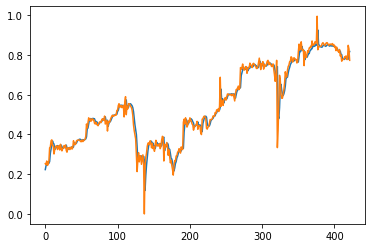

In [18]:
pred_train = model(x_train).detach().numpy().flatten()
act_train = y_train

fig, ax = plt.subplots()
ax.plot(pred_train)
ax.plot(act_train)

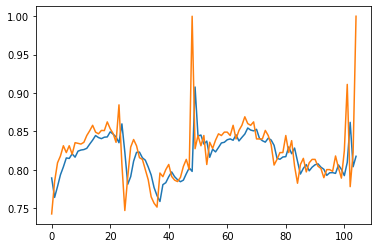

In [19]:
pred_test = model(x_test).detach().numpy().flatten()
act_test = y_test

fig, ax = plt.subplots()
ax.plot(pred_test)
ax.plot(act_test)

In [20]:
all_vals = np.concatenate((x_train.numpy().flatten(), x_test.numpy().flatten()))

new_size = x_train.shape[0] * x_train.shape[1] +  x_test.shape[0] * x_test.shape[1]

all_vals = torch.from_numpy(all_vals.reshape((int(new_size / 19), 19, 1)))
pred_vals = model(all_vals).detach().numpy().flatten()

all_act = np.concatenate((y_train.numpy().flatten(), y_test.numpy().flatten()))

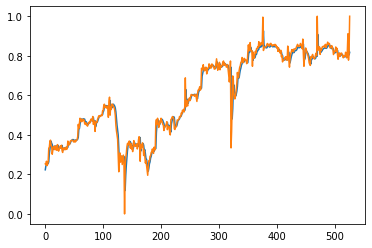

In [21]:
fig, ax = plt.subplots()
ax.plot(pred_vals)
ax.plot(all_act)

In [22]:
future_preds = []
    
window = x_test[-1,:,:]

for i in range(96):
    temp_window = torch.reshape(window, (1, 19, 1))
    curr_pred = model(temp_window)
    curr_pred = curr_pred.detach().numpy().flatten()[0]
    
    future_preds.append(curr_pred)
    
    window = window[1:]
    window = torch.cat((window, torch.from_numpy(np.array([[curr_pred]]))))

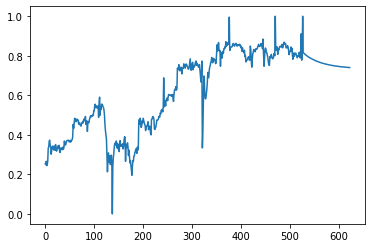

In [23]:
plt.plot(np.concatenate((all_act, np.array(future_preds))))